In [ ]:
from utils import tokenize_with_hex_replacement
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, \
                            roc_curve, f1_score, \
                            precision_recall_curve, roc_curve, \
                            auc, precision_score, recall_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt
import pickle


In [ ]:
with open('models_serialized/tfidf_vectorizer.pkl', 'rb') as file:
    trfr = pickle.load(file)

In [4]:
train = pd.read_parquet('data/train.parquet')
val = pd.read_parquet('data/val.parquet')
test = pd.read_parquet('data/test.parquet')

train.opcode = train.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
val.opcode = val.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
test.opcode = test.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')

In [5]:
X_train_tfidf = trfr.transform(train.opcode)
X_test_tfidf  = trfr.transform(test.opcode)
X_val_tfidf  = trfr.transform(val.opcode)

In [7]:
from sklearn.svm import SVC

params = {'kernel': ['linear'],
          'C': [0.1, 1, 10, 100, 200]}
skf = StratifiedKFold(n_splits=3)
model = GridSearchCV(SVC(probability=True, random_state=42),
                     params,
                     cv=skf,
                     scoring='roc_auc',
                     return_train_score=True,
                     verbose=0,
                     n_jobs=-1,
                     error_score='raise')

model.fit(X_train_tfidf, train.malicious)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise',
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 200], 'kernel': ['linear']},
             return_train_score=True, scoring='roc_auc')

In [8]:
y_pred = model.predict_proba(X_val_tfidf)[:,-1]
y_val = val.malicious

In [9]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = -1  # for infinity

ix = np.argmax(fscore)
print(f'Best Threshold is {thresholds[ix]} with F-Score={fscore[ix]} on validation')
tr = thresholds[ix]

Best Threshold is 0.1544302400932252 with F-Score=0.6666666666666665 on validation


In [10]:
y_pred = model.predict_proba(X_test_tfidf)[:,-1]
y_pred_c = (y_pred > tr)
y_test = test.malicious

------------------------------------TESTING INFO-------------------------------------------------
Roc_Auc on test - 0.9994164382644299
F1 on test - 0.7619047619047619
precision on test - 0.8888888888888888
recall on test - 0.6666666666666666


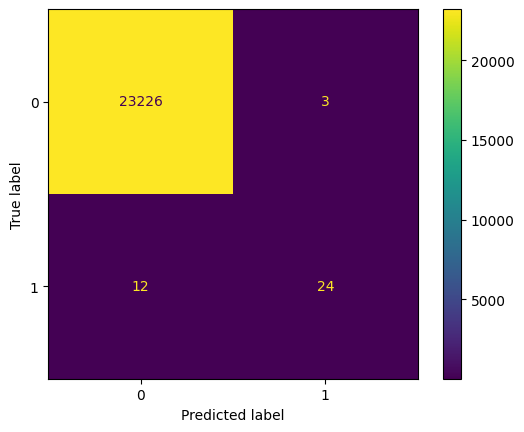

In [11]:
print('------------------------------------TESTING INFO-------------------------------------------------')
print(f'Roc_Auc on test - {roc_auc_score(y_test, y_pred)}')
print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
print(f'precision on test - {precision_score(y_test, y_pred_c)}')
print(f'recall on test - {recall_score(y_test, y_pred_c)}')

cm = confusion_matrix(y_test, y_pred_c, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model.classes_)
disp.plot()
plt.show()

In [16]:
trfr.get_feature_names_out()

array(['add', 'add add', 'add add add', ..., 'xor xor xor push28',
       'xor xor xor swap2', 'xor xor xor xor'], dtype=object)

In [ ]:
imp = pd.DataFrame({'feature_name': trfr.get_feature_names_out(), 
                    'importance' : model.best_estimator_.coef_.toarray().flatten() })
imp_sorted = imp.sort_values(by='importance', ascending=False)

In [34]:
imp_sorted.head(30)

,feature_name,importance
144322,pop,3.101122
148543,pop pop pop pop,2.112280
148119,pop pop,1.887276
148504,pop pop pop,1.880497
159468,push20,1.800618
159469,push20 hex_const,1.800618
210433,swap1 sstore pop push20,1.790877
192071,sstore pop push20,1.789768
192072,sstore pop push20 hex_const,1.789768
149036,pop push20,1.749087


In [35]:
imp_sorted.tail(30)

,feature_name,importance
159520,push20 hex_const and push20,-0.870382
11674,and push20 hex_const and,-0.870453
86127,hex_const and push20 hex_const,-0.875468
86126,hex_const and push20,-0.875468
170590,returndatasize push1 hex_const dup2,-0.885100
48415,dup2 jump,-0.889883
48416,dup2 jump jumpdest,-0.889895
4103,add push2 hex_const jump,-0.898410
132519,mstore push1,-0.914526
132520,mstore push1 hex_const,-0.914526
